<a href="https://colab.research.google.com/github/Shufen-Yin/Artificial-Intelligence/blob/main/Assignment_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
# Task 1 Data preparation
#  1.1 Load dataset
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt

df = pd.read_csv('adult.csv')

print(df.head())

print("Dataset shape:", df.shape)

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

In [ ]:
# 1.2 Basic cleaning: handle missing values

print(df.isnull().sum())

# In the Adult dataset, missing values are as "?"
df = df.replace("?", np.nan)
df = df.dropna()

print("Dataset shape after dropping missing rows:", df.shape)
df.head()


age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64
Dataset shape after dropping missing rows: (45222, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  int64 
 1   workclass        45222 non-null  object
 2   fnlwgt           45222 non-null  int64 
 3   education        45222 non-null  object
 4   educational-num  45222 non-null  int64 
 5   marital-status   45222 non-null  object
 6   occupation       45222 non-null  object
 7   relationship     45222 non-null  object
 8   race             45222 non-null  object
 9   gender           45222 non-null  object
 10  capital-gain     45222 non-null  int64 
 11  capital-loss     45222 non-null  int64 
 12  hours-per-week   45222 non-null  int64 
 13  native-country   45222 non-null  object
 14  income           45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [ ]:
# 2 Preprocess the dataset by selecting features (X) and the target variable (y).
# 2.1 Define target variable (y)
# Convert income (<=50K, >50K) to binary 0/1
df["income_binary"] = df["income"].apply(lambda x: 1 if ">50K" in str(x) else 0)
y = df["income_binary"]

print("Target value counts:")
print(y.value_counts())



Target value counts:
income_binary
0    34014
1    11208
Name: count, dtype: int64


In [ ]:
# 2.2 Define feature matrix (X)
feature_cols = [
    "age",
    "educational-num",
    "hours-per-week",
    "capital-gain",
    "capital-loss",
    "workclass",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "gender"
]

X = df[feature_cols]

print("Feature columns:")
print(X.columns)
X.head()


Feature columns:
Index(['age', 'educational-num', 'hours-per-week', 'capital-gain',
       'capital-loss', 'workclass', 'marital-status', 'occupation',
       'relationship', 'race', 'gender'],
      dtype='object')


,age,educational-num,hours-per-week,capital-gain,capital-loss,workclass,marital-status,occupation,relationship,race,gender
0,25,7,40,0,0,Private,Never-married,Machine-op-inspct,Own-child,Black,Male
1,38,9,50,0,0,Private,Married-civ-spouse,Farming-fishing,Husband,White,Male
2,28,12,40,0,0,Local-gov,Married-civ-spouse,Protective-serv,Husband,White,Male
3,44,10,40,7688,0,Private,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male
5,34,6,30,0,0,Private,Never-married,Other-service,Not-in-family,White,Male


In [ ]:
# 3. Define sensitive attribute for fairness analysis
# Here we use 'gender' as the sensitive attribute
sensitive_attr = "gender"
A = df[sensitive_attr]

print("Sensitive attribute:", sensitive_attr)
print(A.value_counts())


Sensitive attribute: gender
gender
Male      30527
Female    14695
Name: count, dtype: int64


In [ ]:
# Task 2 Model Training and Evaluation:
# 1.1 Split the dataset into training and testing sets.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (31655, 11)
Test shape: (13567, 11)


In [ ]:
# 1.2 Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_features = [
    "age",
    "educational-num",
    "hours-per-week",
    "capital-gain",
    "capital-loss"]

categorical_features = [
    "workclass",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "gender"   ]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)])


In [ ]:
# 2.1Train a logistic regression model using scikit-learn.

# Logistic Regression Model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg_clf.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


In [ ]:
# 3 Evaluation：Accuracy + Confusion Matrix + Classification Report
# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = log_reg_clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.8428539839315987
Confusion Matrix:
[[9463  742]
 [1390 1972]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10205
           1       0.73      0.59      0.65      3362

    accuracy                           0.84     13567
   macro avg       0.80      0.76      0.77     13567
weighted avg       0.84      0.84      0.84     13567



In [ ]:
# Task 3 Fairness analysis
# 1.1 Fairness - Prepare sensitive feature on test set
# We re-split gender along with X and y to keep them aligned
from sklearn.model_selection import train_test_split

sensitive_feature = df["gender"]  # this is the sensitive attribute

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X,
    y,
    sensitive_feature,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("A_test value counts:")
print(A_test.value_counts())


A_test value counts:
gender
Male      9140
Female    4427
Name: count, dtype: int64


In [ ]:
# Re-fit the model after re-splitting
log_reg_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'educational-num',
                                                   'hours-per-week',
                                                   'capital-gain',
                                                   'capital-loss']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
# Install Fairlearn
!pip install fairlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [ ]:
# Fairness - Imports
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    false_positive_rate,
    true_positive_rate
)


In [ ]:
# 2 Fairness - Compute group metrics with MetricFrame
from sklearn.metrics import accuracy_score

# Predicted labels on test set
y_pred = log_reg_clf.predict(X_test)

# Overall accuracy (should be close to 0.8547)
overall_accuracy = accuracy_score(y_test, y_pred)
print("Overall Test Accuracy:", overall_accuracy)

# Define metrics dictionary for MetricFrame
metrics = {
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate,
    "accuracy": accuracy_score
}

# Create MetricFrame grouped by gender (A_test)
mf = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=A_test
)

print("Overall metrics (aggregated):")
print(mf.overall)

print("\nMetrics by gender group:")
print(mf.by_group)


Overall Test Accuracy: 0.8428539839315987
Overall metrics (aggregated):
selection_rate         0.200044
false_positive_rate    0.072709
true_positive_rate     0.586556
accuracy               0.842854
dtype: float64

Metrics by gender group:
        selection_rate  false_positive_rate  true_positive_rate  accuracy
gender                                                                   
Female        0.078609             0.023602            0.483932  0.917551
Male          0.258862             0.103060            0.605718  0.806674


        selection_rate  false_positive_rate  true_positive_rate  accuracy
gender                                                                   
Female        0.078609             0.023602            0.483932  0.917551
Male          0.258862             0.103060            0.605718  0.806674


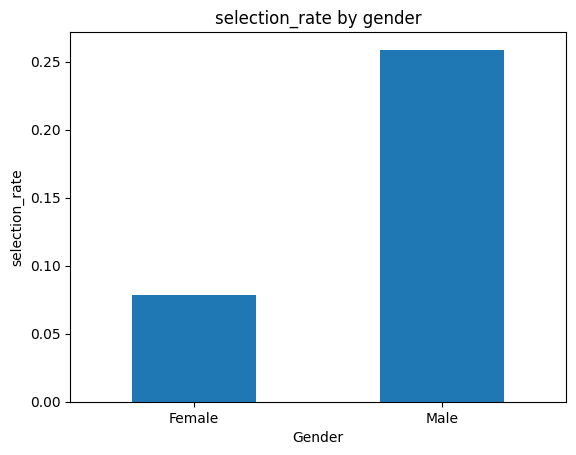

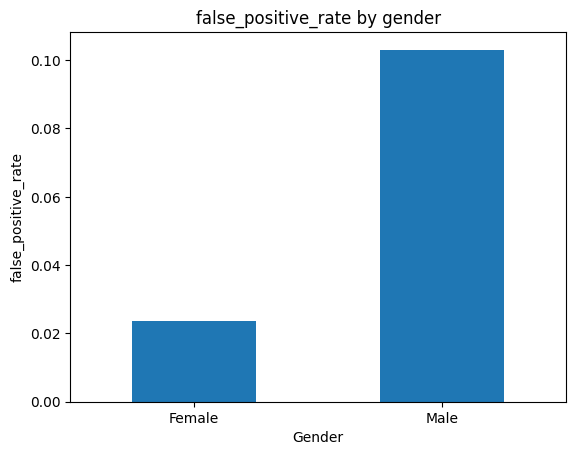

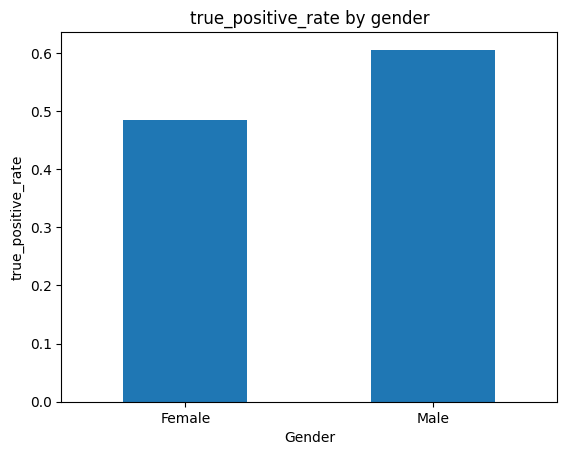

In [ ]:
# Fairness - Custom bar plots with Matplotlib
import matplotlib.pyplot as plt

# Convert by_group to DataFrame
group_metrics = mf.by_group

print(group_metrics)

# Plot selection rate, FPR, TPR in one figure each
for metric_name in ["selection_rate", "false_positive_rate", "true_positive_rate"]:
    group_metrics[metric_name].plot(kind="bar")
    plt.title(f"{metric_name} by gender")
    plt.xlabel("Gender")
    plt.ylabel(metric_name)
    plt.xticks(rotation=0)
    plt.show()


Text(0, 0.5, 'accuracy')

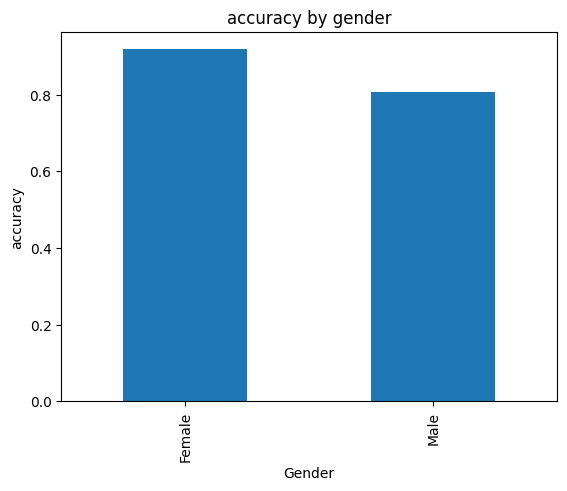

In [ ]:
ax = group_metrics["accuracy"].plot(kind="bar")
ax.set_title("accuracy by gender")
ax.set_xlabel("Gender")
ax.set_ylabel("accuracy")


In [ ]:
# Task 4 Explainability Analysis:
# 1.1 Apply SHAP (SHapley Additive exPlanations) for global and local explainability
#  Explainability - Install SHAP and LIME
!pip install shap lime
# ===== Explainability - Imports =====
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7503d2874df8b88ff8d780e18be91dff35bc118d1097288d8bb79e3e94e7877d
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
#1.2 SHAP - Prepare background data and feature names

# Use training data as background; sample a subset for efficiency
X_train_sample = X_train.sample(n=200, random_state=42)  # you can adjust n

# Get feature names after preprocessing (for plots)
# We need to fit the preprocessor separately to extract names
preprocessor = log_reg_clf.named_steps["preprocessor"]

# Fit preprocessor on full training data (if not already fitted)
preprocessor.fit(X_train)

# Get transformed feature names (numeric + one-hot categorical)
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][2]

# OneHotEncoder is the second transformer
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, ohe_feature_names])
print("Number of features after preprocessing:", len(all_feature_names))


Number of features after preprocessing: 46


In [ ]:
# 1.3 SHAP - Build KernelExplainer for the pipeline

# Define a wrapper to get probability of positive class from the pipeline

# Safe model wrapper for DataFrame input
feature_cols = X_train.columns  # original feature names

def model_predict_proba(X_input):
    """
    SHAP may pass a numpy array. We need to convert it back to a DataFrame
    with the same column names as the original training data.
    """
    import numpy as np
    import pandas as pd

    if isinstance(X_input, np.ndarray):
        X_df = pd.DataFrame(X_input, columns=feature_cols)
    else:
        # already a DataFrame
        X_df = X_input

    return log_reg_clf.predict_proba(X_df)[:, 1]

# Create a KernelExplainer using a small background set
X_train_sample = X_train.sample(n=50, random_state=42)  # keep as DataFrame

explainer = shap.KernelExplainer(
    model_predict_proba,
    X_train_sample
)

  0%|          | 0/300 [00:00<?, ?it/s]

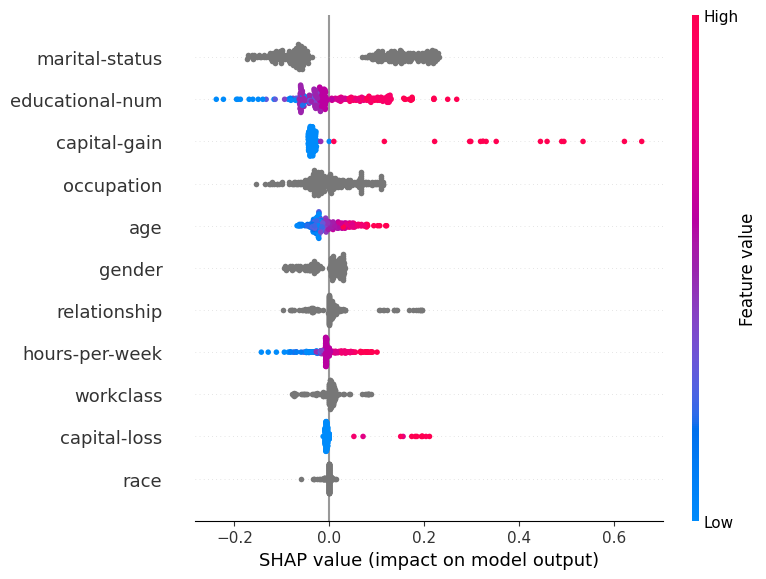

In [ ]:
#  SHAP - Compute shap_values for a test subset
X_test_sample = X_test.sample(n=300, random_state=0)  # DataFrame

shap_values = explainer.shap_values(X_test_sample, nsamples=100)

#summary plot
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=X_test_sample.columns
)


In [ ]:
# 2.1 Use LIME (Local Interpretable Model-agnostic Explanations) for detailed interpretation of individual predictions.
#  LIME - Imports
from lime.lime_tabular import LimeTabularExplainer


In [ ]:
# 2.2Identify numeric and categorical columns
numeric_cols = ['age', 'educational-num', 'hours-per-week']  # adjust
categorical_cols = [col for col in X_train.columns if col not in numeric_cols]

# One-hot encode categorical columns
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train[categorical_cols])
X_test_cat = ohe.transform(X_test[categorical_cols])

# Concatenate numeric columns
X_train_num = X_train[numeric_cols].values
X_test_num = X_test[numeric_cols].values
X_train_lime = np.hstack([X_train_num, X_train_cat])
X_test_lime = np.hstack([X_test_num, X_test_cat])

# Feature names
feature_names = numeric_cols + list(ohe.get_feature_names_out(categorical_cols))



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# 2.3. Build LIME Tabular Explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_lime,
    feature_names=feature_names,
    class_names=["<=50K", ">50K"],
    discretize_continuous=True,
    mode="classification",
    random_state=42
)

In [ ]:
# 2.4 Explain a single test instance
# Train a Logistic Regression on manually one-hot encoded data

log_reg_manual = LogisticRegression(max_iter=5000)
log_reg_manual.fit(X_train_lime, y_train)  # use manually one-hot encoded X_train

# 2.5 Explain a single test instance with LIME
i = 0  # choose which test instance
i = 0  # choose which test instance
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_lime[i],          # use manually one-hot encoded test row
    predict_fn=log_reg_manual.predict_proba,  # call the manually trained model
    num_features=10
)

In [ ]:
# Print explanation
print("LIME explanation for test instance", i)
print(lime_exp.as_list())


LIME explanation for test instance 0
[('capital-gain_7298 <= 0.00', -0.660550832471564), ('capital-gain_8614 <= 0.00', -0.6366863028065071), ('capital-loss_1564 <= 0.00', -0.6076374302221501), ('capital-gain_99999 <= 0.00', -0.5758811055554053), ('capital-loss_1887 <= 0.00', -0.5695421214109085), ('capital-gain_7688 <= 0.00', -0.5649224103900153), ('capital-gain_13550 <= 0.00', -0.5580248504735157), ('capital-gain_27828 <= 0.00', -0.448969215611842), ('capital-gain_10520 <= 0.00', -0.40977110048958), ('capital-loss_2559 <= 0.00', -0.32159944579037175)]


In [88]:
!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace "Assignment_14.ipynb"
!jupyter nbconvert --ClearWidgetsPreprocessor.enabled=True --inplace "Assignment_14.ipynb"


[NbConvertApp] Converting notebook Assignment_14.ipynb to notebook
[NbConvertApp] Writing 30743 bytes to Assignment_14.ipynb
[NbConvertApp] Converting notebook Assignment_14.ipynb to notebook
[NbConvertApp] Writing 30743 bytes to Assignment_14.ipynb


In [89]:
!jupyter nbconvert --ClearOutputPreprocessor.enabled=True \
                   --ClearWidgetsPreprocessor.enabled=True \
                   --inplace "Assignment_14.ipynb"


[NbConvertApp] Converting notebook Assignment_14.ipynb to notebook
[NbConvertApp] Writing 30743 bytes to Assignment_14.ipynb
